In [1]:
using Chemfiles
using Plots
using DataFrames, FileIO

home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_middle, out_counts
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

In [5]:
pdb = "4xcp"
# Leo modos
modes_4xcp, evals_4xcp = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4xcp))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4xcp = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4xcp = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4xcp = eval(:(ndd_out_4xcp .- vol_avg_4xcp))
vgv_4xcp = vgv_4xcp ./ norm(vgv_4xcp);

dif = readdlm(joinpath(rtdos, string("diff_", pdb)))
nframes = size(dif)[2]
norm_dif = mapslices(x -> x ./ norm(x), dif, 1);

prj_1_4xcp = Array{Float64, 1}(nframes)
prj_2_4xcp = Array{Float64, 1}(nframes)
prj_3_4xcp = Array{Float64, 1}(nframes)
prj_4_4xcp = Array{Float64, 1}(nframes)
prj_5_4xcp = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 1])
    prj_2_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 2])
    
    prj_3_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 3])
    prj_4_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 4])
    prj_5_4xcp[i] = dot(norm_dif[:, i], modes_4xcp[:, 5])
end

# Smooth
smooth_prj_1_4xcp = [ mean(prj_1_4xcp[i:i+9]) for i = 1:10:length(prj_1_4xcp)-9 ]
smooth_prj_2_4xcp = [ mean(prj_2_4xcp[i:i+9]) for i = 1:10:length(prj_2_4xcp)-9 ]

smooth_prj_3_4xcp = [ mean(prj_3_4xcp[i:i+9]) for i = 1:10:length(prj_3_4xcp)-9 ]
smooth_prj_4_4xcp = [ mean(prj_4_4xcp[i:i+9]) for i = 1:10:length(prj_4_4xcp)-9 ]
smooth_prj_5_4xcp = [ mean(prj_5_4xcp[i:i+9]) for i = 1:10:length(prj_5_4xcp)-9 ];

# Volumen
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

In [7]:
# Smooth
prj_1 = [ mean(prj_1_4xcp[i:i+90]) for i = 1:100:length(prj_1_4xcp)-90 ]
prj_2 = [ mean(prj_2_4xcp[i:i+90]) for i = 1:100:length(prj_2_4xcp)-90 ]

prj_3 = [ mean(prj_3_4xcp[i:i+90]) for i = 1:100:length(prj_3_4xcp)-90 ]
prj_4 = [ mean(prj_4_4xcp[i:i+90]) for i = 1:100:length(prj_4_4xcp)-90 ]
prj_5 = [ mean(prj_5_4xcp[i:i+90]) for i = 1:100:length(prj_5_4xcp)-90 ];

prj =  [ prj_1 prj_2 prj_3 prj_4 prj_5 ];

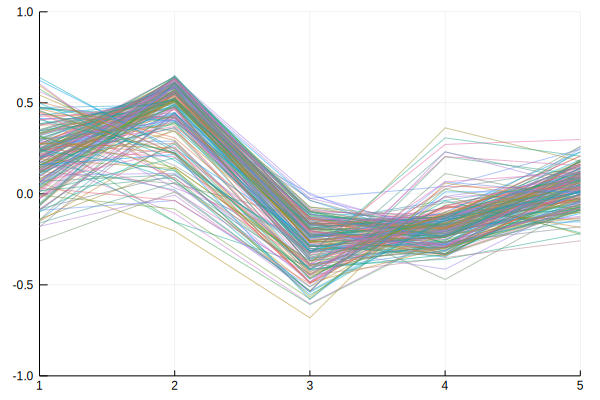

In [8]:
plot(transpose(prj)[:, 1:200],
    ylims = (-1,1),
    legend = false, linealpha = .5)

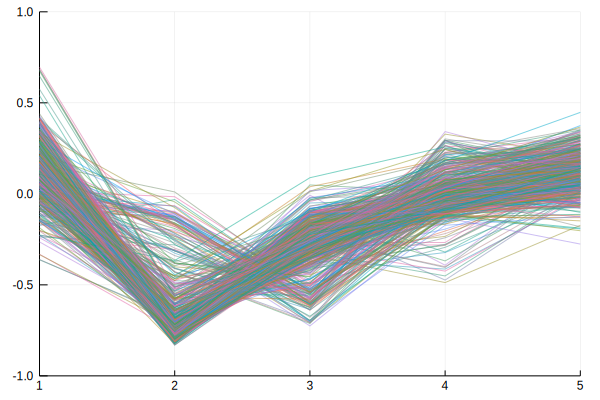

In [9]:
plot(transpose(prj)[:, 250:800],
    ylims = (-1,1),
    legend = false, linealpha = .5)

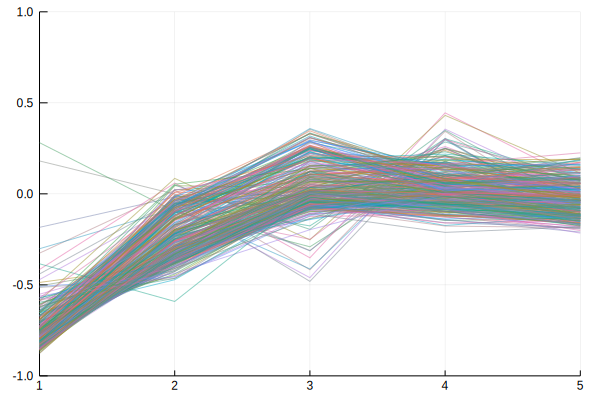

In [10]:
plot(transpose(prj)[:, 965:1300],
    ylims = (-1,1),
    legend = false, linealpha = .5)

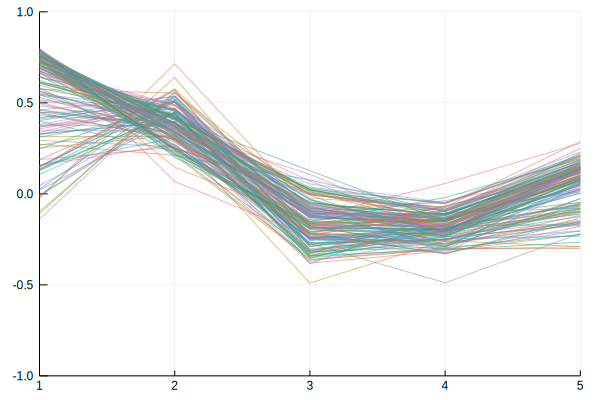

In [11]:
plot(transpose(prj)[:, 1390:1550],
    ylims = (-1,1),
    legend = false, linealpha = .5)

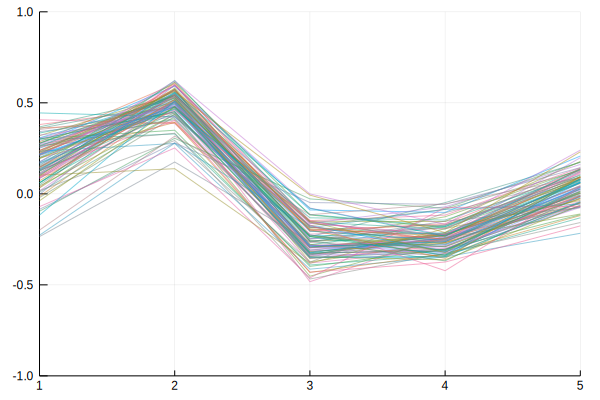

In [12]:
plot(transpose(prj)[:, 1650:1750],
    ylims = (-1,1),
    legend = false, linealpha = .5)

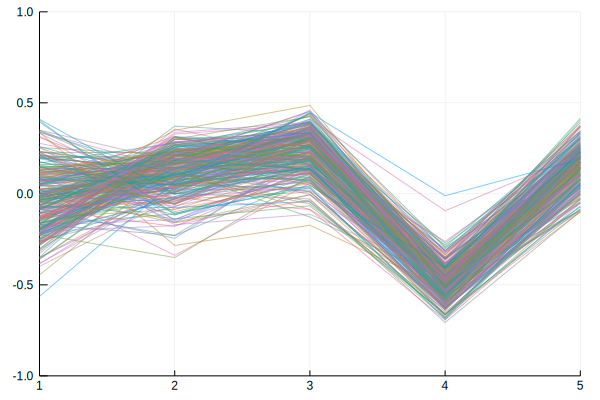

In [13]:
plot(transpose(prj)[:, 1800:2100],
    ylims = (-1,1),
    legend = false, linealpha = .5)

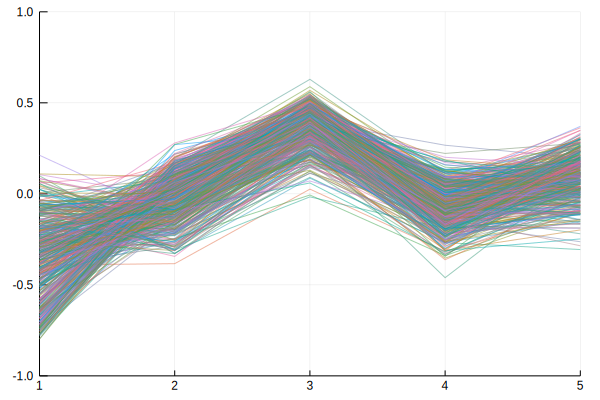

In [14]:
plot(transpose(prj)[:, 2200:2700],
    ylims = (-1,1),
    legend = false, linealpha = .5)

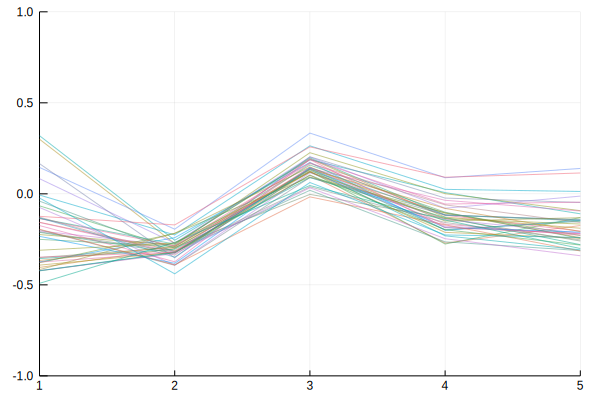

In [15]:
plot(transpose(prj)[:, 2800:2840],
    ylims = (-1,1),
    legend = false, linealpha = .5)

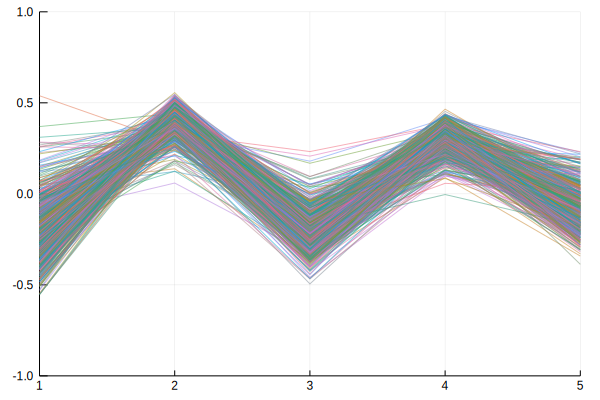

In [16]:
plot(transpose(prj)[:, 2900:3500],
    ylims = (-1,1),
    legend = false, linealpha = .5)

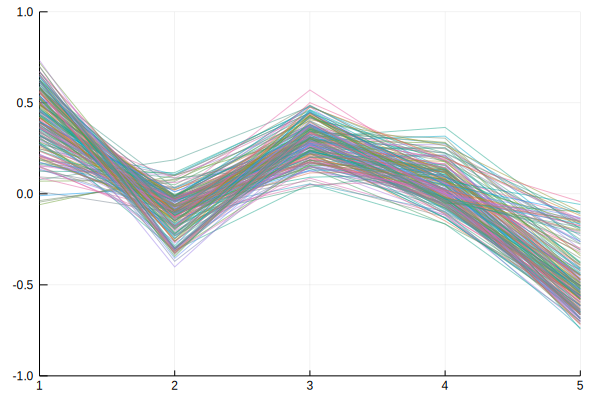

In [17]:
plot(transpose(prj)[:, 4000:4200],
    ylims = (-1,1),
    legend = false, linealpha = .5)

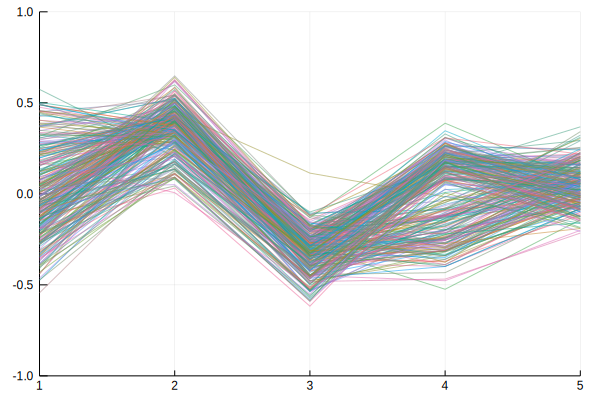

In [18]:
plot(transpose(prj)[:, 4700:5000],
    ylims = (-1,1),
    legend = false, linealpha = .5)

In [23]:
# Hago esto 1 sola vez
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_4xcp, prj_2_4xcp, in_bins, in_bins);

msk = his .> 125
main_his = his[msk]
main_his_ind = his_ind[msk];

# 0
spy(msk[40:60, 6:16])
# 1
spy(msk[67:73, 27:35])
# 2
spy(msk[69:75, 52:62])
# 3
spy(msk[27:57, 39:63])
# 4
spy(msk[4:17, 19:50])

idx_vol0 = collect(Iterators.flatten(his_ind[40:60, 6:16]))
idx_vol1 = collect(Iterators.flatten(his_ind[67:73, 27:35]))
idx_vol2 = collect(Iterators.flatten(his_ind[69:75, 52:62]))
idx_vol3 = collect(Iterators.flatten(his_ind[27:57, 39:63]))
idx_vol4 = collect(Iterators.flatten(his_ind[4:17, 19:50]));

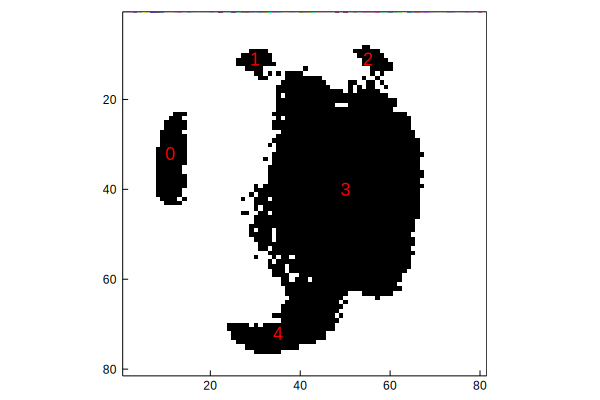

In [41]:
spy(msk)
annotate!(11, 32, text("0", 12, :red))
annotate!(30, 11, text("1", 12, :red))
annotate!(55, 11, text("2", 12, :red))
annotate!(50, 40, text("3", 12, :red))
annotate!(35, 72, text("4", 12, :red))

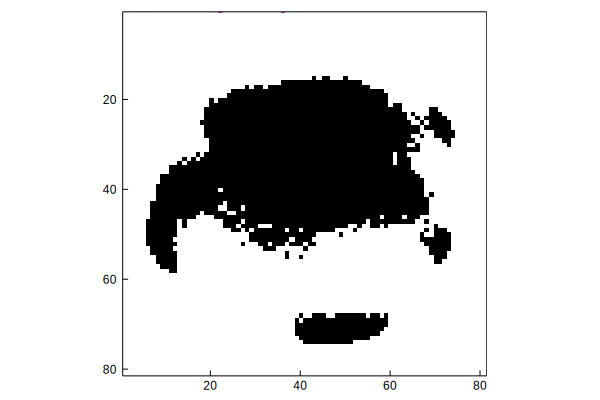

In [82]:
spy(transpose(msk))

In [73]:
min_frm = 150
########### 1 ###########
#
in_bins = collect(-1:.025:1)
his_ind_12, his_12 = MatHisInd2D(prj_1_4xcp, prj_2_4xcp, in_bins, in_bins);

msk_12 = his_12 .> min_frm
main_his_12 = his_12[msk_12]
main_his_ind_12 = his_ind_12[msk_12];

#
in_bins = collect(-1:.025:1)
his_ind_13, his_13 = MatHisInd2D(prj_1_4xcp, prj_3_4xcp, in_bins, in_bins);

msk_13 = his_13 .> min_frm
main_his_13 = his_13[msk_13]
main_his_ind_13 = his_ind_13[msk_13];

#
in_bins = collect(-1:.025:1)
his_ind_14, his_14 = MatHisInd2D(prj_1_4xcp, prj_4_4xcp, in_bins, in_bins);

msk_14 = his_14 .> min_frm
main_his_14 = his_14[msk_14]
main_his_ind_14 = his_ind_14[msk_14];

#
in_bins = collect(-1:.025:1)
his_ind_15, his_15 = MatHisInd2D(prj_1_4xcp, prj_5_4xcp, in_bins, in_bins);

msk_15 = his_15 .> min_frm
main_his_15 = his_15[msk_15]
main_his_ind_15 = his_ind_15[msk_15];

########### 2 ###########
#
in_bins = collect(-1:.025:1)
his_ind_23, his_23 = MatHisInd2D(prj_2_4xcp, prj_3_4xcp, in_bins, in_bins);

msk_23 = his_23 .> min_frm
main_his_23 = his_23[msk_23]
main_his_ind_23 = his_ind_23[msk_23];

#
in_bins = collect(-1:.025:1)
his_ind_24, his_24 = MatHisInd2D(prj_2_4xcp, prj_4_4xcp, in_bins, in_bins);

msk_24 = his_24 .> min_frm
main_his_24 = his_24[msk_24]
main_his_ind_24 = his_ind_24[msk_24];

#
in_bins = collect(-1:.025:1)
his_ind_25, his_25 = MatHisInd2D(prj_2_4xcp, prj_5_4xcp, in_bins, in_bins);

msk_25 = his_25 .> min_frm
main_his_25 = his_25[msk_25]
main_his_ind_25 = his_ind_25[msk_25];

########### 3 ###########
#
in_bins = collect(-1:.025:1)
his_ind_34, his_34 = MatHisInd2D(prj_3_4xcp, prj_4_4xcp, in_bins, in_bins);

msk_34 = his_34 .> min_frm
main_his_34 = his_34[msk_34]
main_his_ind_34 = his_ind_34[msk_34];

#
in_bins = collect(-1:.025:1)
his_ind_35, his_35 = MatHisInd2D(prj_3_4xcp, prj_5_4xcp, in_bins, in_bins);

msk_35 = his_35 .> min_frm
main_his_35 = his_35[msk_35]
main_his_ind_35 = his_ind_35[msk_35];

########### 4 ###########
in_bins = collect(-1:.025:1)
his_ind_45, his_45 = MatHisInd2D(prj_4_4xcp, prj_5_4xcp, in_bins, in_bins);

msk_45 = his_45 .> min_frm
main_his_45 = his_45[msk_45]
main_his_ind_45 = his_ind_45[msk_45];


In [75]:
msk_1 = msk_12 .& msk_13 .& msk_14 .& msk_15
msk_2 = msk_12 .& msk_23 .& msk_24 .& msk_25
msk_3 = msk_13 .& msk_23 .& msk_34 .& msk_35
msk_4 = msk_14 .& msk_24 .& msk_34 .& msk_45
msk_5 = msk_15 .& msk_25 .& msk_35 .& msk_45

msk_ = msk_1 .& msk_2 .& msk_3 .& msk_4 .& msk_5;

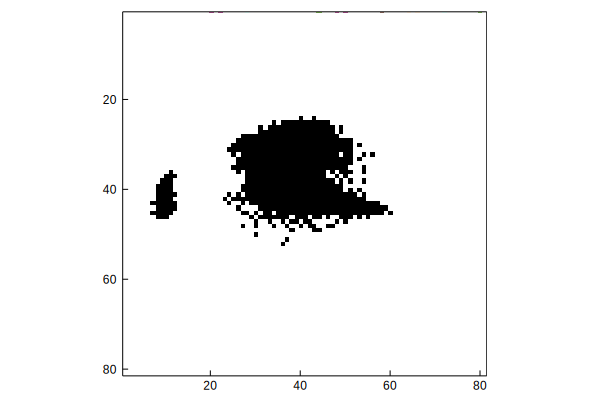

In [76]:
spy(transpose(msk_1))

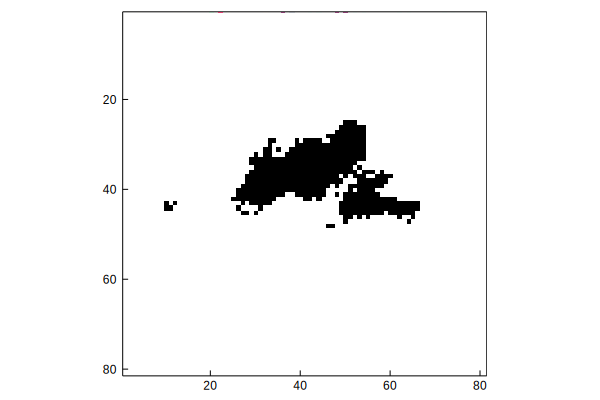

In [77]:
spy(transpose(msk_2))

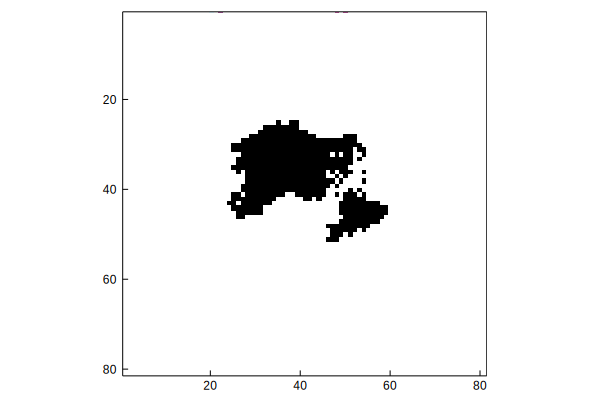

In [78]:
spy(transpose(msk_3))

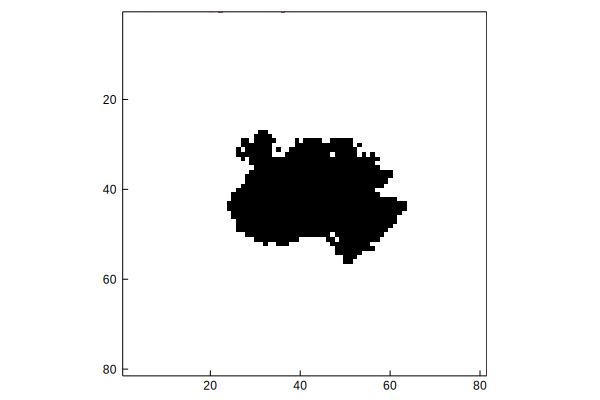

In [79]:
spy(transpose(msk_4))

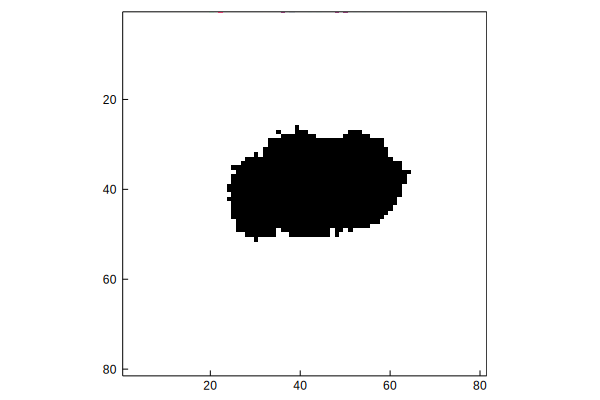

In [80]:
spy(transpose(msk_5))

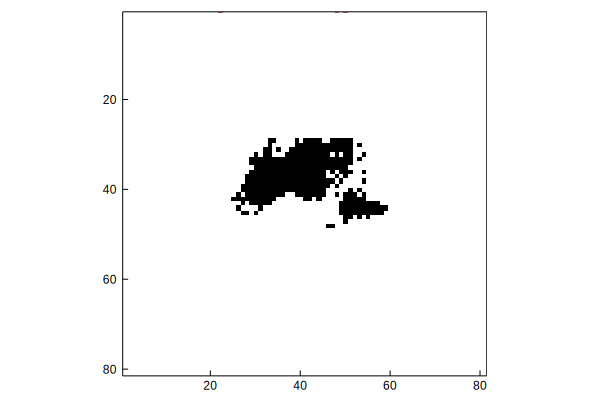

In [81]:
spy(transpose(msk_))

In [166]:
delta = 4
lm_1 = mean(prj_1_4xcp) - std(prj_1_4xcp) / delta
rm_1 = mean(prj_1_4xcp) + std(prj_1_4xcp) / delta

lm_2 = mean(prj_2_4xcp) - std(prj_2_4xcp) / delta
rm_2 = mean(prj_2_4xcp) + std(prj_2_4xcp) / delta

lm_3 = mean(prj_3_4xcp) - std(prj_3_4xcp) / delta
rm_3 = mean(prj_3_4xcp) + std(prj_3_4xcp) / delta

lm_4 = mean(prj_4_4xcp) - std(prj_4_4xcp) / delta
rm_4 = mean(prj_4_4xcp) + std(prj_4_4xcp) / delta

lm_5 = mean(prj_5_4xcp) - std(prj_5_4xcp) / delta
rm_5 = mean(prj_5_4xcp) + std(prj_5_4xcp) / delta

DataFrame([ lm_1 rm_1 ; lm_2 rm_2 ; lm_3 rm_3 ; lm_4 rm_4 ; lm_5 rm_5 ])

,x1,x2
1,-0.13028964046742897,0.07737994224637296
2,-0.05781872358072757,0.13016295181775164
3,-0.08869297618025418,0.06883111012372792
4,-0.07454217864078158,0.06629907409824207
5,-0.045982506272457674,0.06816344148479253


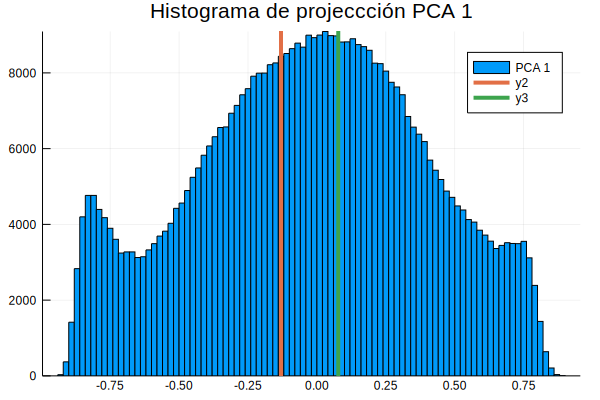

In [167]:
histogram(prj_1_4xcp, label = "PCA 1")
vline!([lm_1 rm_1], line = 4)
title!("Histograma de projeccción PCA 1")

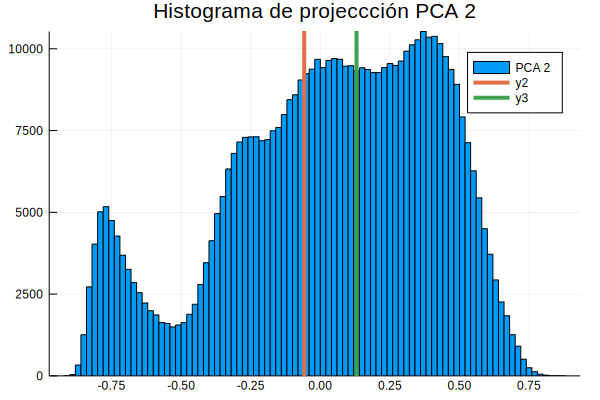

In [175]:
histogram(prj_2_4xcp, label = "PCA 2")
vline!([lm_2 rm_2], line = 4)
title!("Histograma de projeccción PCA 2")

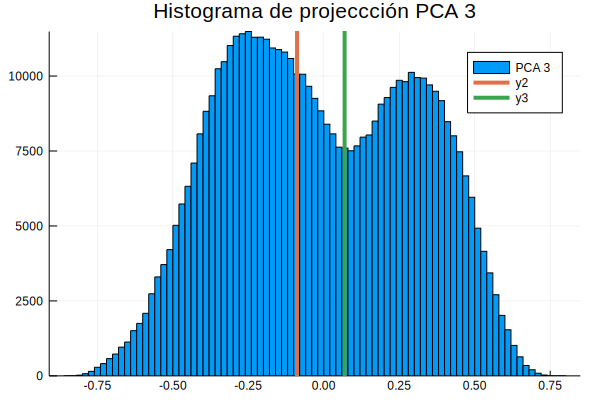

In [176]:
histogram(prj_3_4xcp, label = "PCA 3")
vline!([lm_3 rm_3], line = 4)
title!("Histograma de projeccción PCA 3")

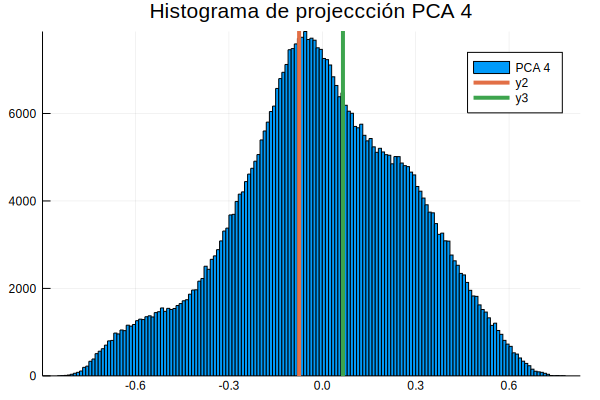

In [177]:
histogram(prj_4_4xcp, label = "PCA 4")
vline!([lm_4 rm_4], line = 4)
title!("Histograma de projeccción PCA 4")

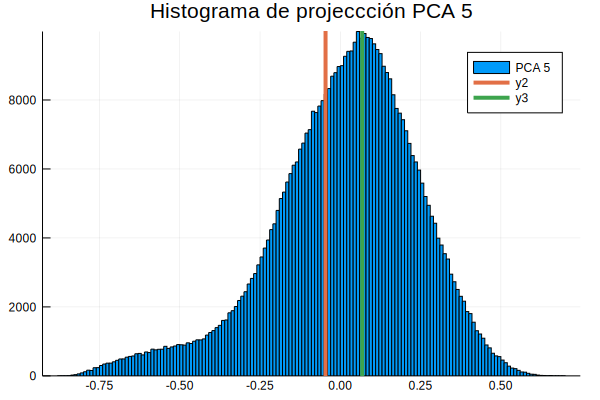

In [178]:
histogram(prj_5_4xcp, label = "PCA 5")
vline!([lm_5 rm_5], line = 4)
title!("Histograma de projeccción PCA 5")

In [179]:
lo_vol_idx = (prj_1_4xcp .< lm_1) .& (prj_2_4xcp .< lm_2) .& 
    (prj_3_4xcp .> rm_3) .& (prj_4_4xcp .> rm_4) .& (prj_5_4xcp .< lm_5 );


hi_vol_idx = (prj_1_4xcp .> rm_1) .& (prj_2_4xcp .> rm_2) .& 
    (prj_3_4xcp .< lm_3) .& (prj_4_4xcp .< lm_4) .& (prj_5_4xcp .> rm_5 );

lo_vol = findn(lo_vol_idx)
hi_vol = findn(hi_vol_idx)

writedlm(joinpath(rtdos, string(pdb,"_idx_lo_vol")), lo_vol)
writedlm(joinpath(rtdos, string(pdb,"_idx_hi_vol")), hi_vol)

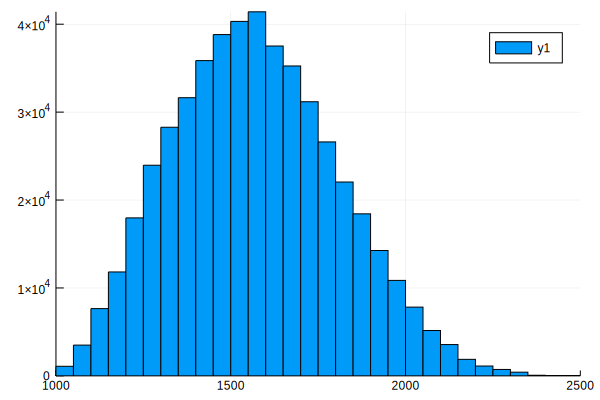

In [170]:
histogram(full_trj_vol,
    bins = 50,
    xlims = (1000, 2500))

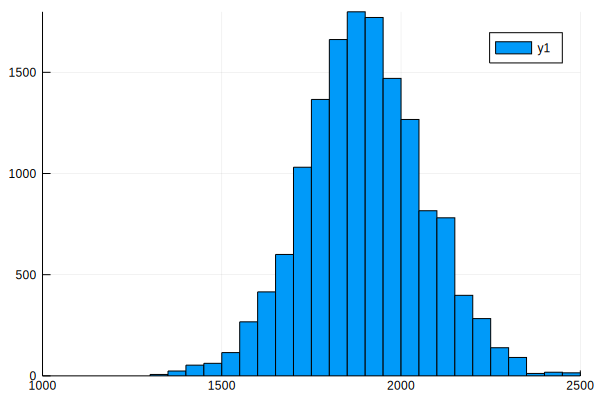

In [171]:
histogram(full_trj_vol[hi_vol_idx],
    bins = 50,
    xlims = (1000, 2500))

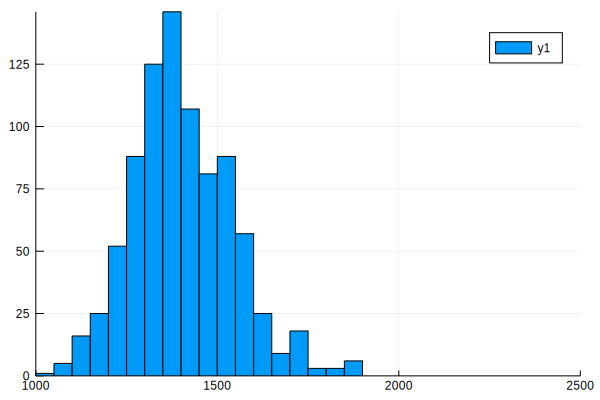

In [172]:
histogram(full_trj_vol[lo_vol_idx],
    xlims = (1000, 2500))

## Distancia lig

In [185]:
const c1 = 2427
const cg = 2444

function limito_scope(c1, cg, in_trj_filename)
    # Uso esto p/ dividir las trayectorias a escribir en 4 partes y q
    # no me llenen la memoria
    in_trj = Trajectory(in_trj_filename)
    nframes = nsteps(in_trj)
    distancias = Array{Float64, 1}(nframes)
    close(in_trj)
    idx_ = convert(Int64, ceil(nframes / 10))
    tmp = [ collect(1:idx_:nframes) ; nframes ]
    
    
    for j in 1:length(tmp) - 1
        if j == 1
            in_trj = Trajectory(in_trj_filename)
            for i in tmp[j]:tmp[j+1]
                in_frm = read_step(in_trj, i - 1)
                distancias[i] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
            end
            close(in_trj)
        else
            in_trj = Trajectory(in_trj_filename)
            for i in tmp[j]+1:tmp[j+1]
                in_frm = read_step(in_trj, i - 1)
                distancias[i] = norm(positions(in_frm)[:, c1] - positions(in_frm)[:, cg])
            end
            close(in_trj)
        end
        println(j)
        gc()
    end
    return distancias
end

dis_lig_lo = limito_scope(c1, cg, joinpath(home, pdb, "poblaciones", "vollo_4xcp.nc"))
dis_lig_hi = limito_scope(c1, cg, joinpath(home, pdb, "poblaciones", "volhi_4xcp.nc"));

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


In [186]:
bin_dis = collect(4.:.3:20.)

# Histograma ponderado
bin_lo, his_lo = WeightedHist(dis_lig_lo, bin_dis, fill(1., length(dis_lig_lo)), true);
bin_hi, his_hi = WeightedHist(dis_lig_hi, bin_dis, fill(1., length(dis_lig_hi)), true);

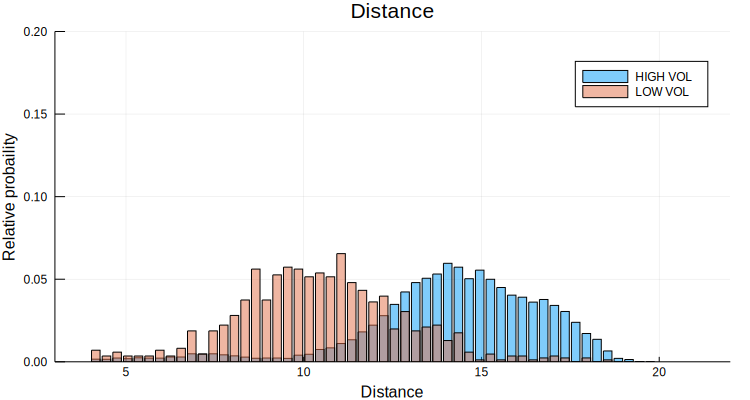

In [192]:
plt_dis_lig = bar(bin_hi, his_hi,
    xlims = (3, 22), ylims = (0, .2),
    yaxis = "Relative probaility", xaxis = "Distance", title = "Distance",
    label = "HIGH VOL", size = (750, 400), fillalpha = .5)
bar!(plt_dis_lig, bin_lo, his_lo,
    label = "LOW VOL", fillalpha = .5)